In [1]:
import os
# Filter out logs (additional) : 0 - all logs, 1 - INFO, 2 - WARNING, 3 - ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'}
import sys
import numpy as np
import datetime
import random
import pickle
from glob import glob
import tensorflow as tf

from src.data_preparation import coloc_dataset
from src.modelling import model_distri
from src.utils import tardisml_utils
from src.utils import load_Dconfig
   
def convert_y_to_proba(sp_distri, bins=None):
    '''Convert distribution of X samples to distribution on SIT TOPAZ5 categories

    Convert y from array of values (raw distributions)
                 to  probabilities of bins (distributions projected on bins)

    Parameters:
    -----------

        bins     :    if None, bins of TOPAZ5 sea ice categories will be used


    Normalization:
    https://stackoverflow.com/questions/5498008/pylab-histdata-normed-1-normalization-seems-to-work-incorrect

    '''

    if bins is None:
        bins = np.array([0, 0.64, 1.39, 2.47, 4.57, 30])


    # y_tmp = self.sp_distri.copy()

    n = sp_distri.shape[0]
    nbins = len(bins)-1
    y_prob = np.zeros((n, nbins))

    for idx in range(n):
        # instead of : density=True (shows sum >1 in some cases), using weights 
        y_prob[idx] = np.histogram(sp_distri[idx], bins=bins, 
                                   weights=np.ones_like(sp_distri[idx])/float(len(sp_distri[idx]))
                                  )[0]

    #self.sp_distri = y_prob
    return y_prob

2024-03-13 17:45:34.717523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /LUMI_CONTAINER/env1/lib:/LUMI_CONTAINER/env1/lib64:/opt/cray/pe/papi/7.0.1.1/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/.singularity.d/libs
2024-03-13 17:45:36.105152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /LUMI_CONTAINER/env1/lib:/LUMI_CONTAINER/env1/lib64:/opt/cray/pe/papi/7.0.1.1/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/.singularity.d/libs
2024-03-13 17:45:36.105240: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot 

In [8]:
file_dconfig = '../config/distri/Dconfig_sia_2018-10days.yaml'

In [3]:
# ---------------------------------------------------
#               Activate gpu if possible
# ---------------------------------------------------
ngpu = len(tf.config.list_physical_devices('GPU'))
print("\nNum GPUs Available: ", ngpu)


# print(tf.__version__)
# print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(f'GPU device name:{tf.test.gpu_device_name()}')

# activation GPU
if ngpu > 0:
    tf.debugging.set_log_device_placement(True)  # debug: print placement (CPU or GPU) of operations
    print('Activation GPU')
    # print('CPU only')

    


Num GPUs Available:  0
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
GPU device name:


2024-03-13 17:46:43.864949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /LUMI_CONTAINER/env1/lib:/LUMI_CONTAINER/env1/lib64:/opt/cray/pe/papi/7.0.1.1/lib64:/opt/cray/libfabric/1.15.2.0/lib64:/.singularity.d/libs
2024-03-13 17:46:43.864988: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [10]:
# ---------------------------------------------------
#                 Defining parameters
# ---------------------------------------------------

rootdir = tardisml_utils.get_rootdir()

config = load_Dconfig.DConfig(file_dconfig, rootdir=rootdir, verbose=1)


d1 = config.d1
d2 = config.d2

var_to_exclude = config.var_to_exclude

batch_size = config.batch_size
epochs = config.epochs

random_state = config.random_state

Config file found: ../config/distri/Dconfig_sia_2018-10days.yaml
PCA results in: /scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j150-629
Config file updated 'pca_dir': ../config/distri/Dconfig_sia_2018-10days.yaml
Results in: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730
Folder created

Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730/ml/
Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730/figures/
Config file updated 'results_dir': ../config/distri/Dconfig_sia_2018-10days.yaml
Config folders updated.
Config copied to: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730
Config file found: /scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730/Dconfig_sia_2018-10days.yaml
Default config file is now the copied following one:
/scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730/Dconfig_sia_2018-10days.yaml


In [11]:
import copy

In [12]:
copy.deepcopy(2)

2

In [14]:
from importlib import reload

In [17]:
reload(coloc_dataset)

<module 'src.data_preparation.coloc_dataset' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/coloc_dataset.py'>

In [18]:
# ----------------------------------------
#               Import dataset
# ----------------------------------------

y_as_proba = False  # True
nbins = 5  # Sea ice categories of TOPAZ5


# Dates to import dataset
# d1 = datetime.datetime(2018, 10, 14)
# d2 = datetime.datetime(2018, 11, 14) 
# d2 = datetime.datetime(2019, 4, 30)
# d2 = datetime.datetime(2022, 4, 30) 

tmp_days = np.array([d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)])
# remove non valid days
all_days = coloc_dataset.check_valid_days(tmp_days)


# ['SIT', 'month', 'lat', 'lon', 'siconc', 'sisnthick', 'zos', 'vxsi', 'vysi', 
# '2T', 'MSL', 'TP', '10V', '10U', 'SSR', 'STR', 'sia']
# var_to_exclude = ['lon', 'sia']


ds = coloc_dataset.DatasetTrain(days=all_days, config=config,
                                rootdir=rootdir, ml_dir=config.ml_dir, y_as_proba=y_as_proba)


# ds.exclude_var(var_to_exclude=var_to_exclude)

# ds.check_nan()
# ds.dataset_split()
# ds.assemble_dataset(scaling=True, var_to_exclude=var_to_exclude)

Config file updated 'random_state': /scratch/project_465000269/edelleo1/Leo/results/distri_240313-174730/Dconfig_sia_2018-10days.yaml
Importing...
	 2018-11-14
[0.84213333 0.83383493 0.81300782 0.85585073 0.80937374 0.8517703
 1.0165599  1.04304361 1.32113052 1.3910864  1.53082347 1.61894114
 1.47229419 1.47969325 1.44862013 1.43289343 1.41329532 1.49333514
 1.4705452  1.47548972 1.43865066 1.4138524  1.39429147 1.34630438
 1.36499457 0.9342941  0.86648147 0.86235874 0.85932953 0.85493289
 0.82771605 1.32113052 1.47229419 1.47137415 1.4705452  1.4138524
 1.47779883 1.46565021 1.44765272 0.91099437 0.87507175 0.87638233
 0.84725235 0.84319822 0.83112981 0.82051354 0.8517703  1.0165599
 1.53082347 1.44862013 1.46398498 1.39904556 1.34571793 1.37274035
 1.46565021 1.47095376]
[0.16045468 0.15933588 0.16283991 0.16132002 0.16091871 0.16327787
 0.16366852 0.16313786 0.16339902 0.16391072 0.16397495 0.16431062
 0.16428619 0.1642863  0.1642863  0.16403532 0.16373056 0.16245353
 0.16245353 0.1

[0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1        2.36347964 2.51926414 2.51926414
 1.17755469 1.17755469 1.03698819 1.01618422 0.16438356 0.16438181
 0.16438356 0.16438356 0.16438356 0.16438356 0.16438356 0.16438356
 0.16438356 0.16354308 0.16336843 0.16302344 0.1626635  0.1626635
 0.16103185 0.16097368 0.15939566 0.15875695 0.15801035 0.15801035
 0.15823588 0.15827865 0.15907489 0.15853814 0.1586187  0.15833685
 0.15847952 0.15771114 0.15771114 0.15654601 0.15654601 0.15576576
 0.15576576 0.15430661 0.15592047 0.15518142 0.15525716 0.15369912
 0.14604122 0.14644224 0.1        0.1        0.1        2.51926414
 0.91397228 0.91397228 0.83240009 0.83240009 0.80740635 0.80163601
 0.76168882 0.72011688 0.68831787 0.62624127 0.55026081 0.50653268
 0.48987766 0.48505076 0.44484804 0.4539403  0.16438356 0.16438356
 0.16438356 0.16436278 0.16434044 0.16438356 0.15757954 0.15837392
 0.1585381

[0.15838645 0.15944198 0.16040415 0.16116667 0.16021102 0.16154226
 0.16155019 0.16026744 0.15967515 0.16063981 0.16067027 0.16067027
 0.1608037  0.16144328 0.16155105 0.16143347 0.16125768 0.1613336
 0.16167571 0.16218617 0.16387541 0.16387541 0.16445406 0.16553192
 0.16547123 0.16601484 0.16627058 0.16688359 0.16688359 0.16709846
 0.16709781 0.16709781 0.16712329 0.16712329 0.16712339 0.16712339
 0.16733418 0.18870933 0.18870933 0.20401713 0.18971532 0.22309058
 0.24915774 0.25155566 0.25155566 0.28649458 0.32366821 0.36178442
 0.36178442 0.33588884 0.4075726  0.40451943 0.43883523 0.43883523
 0.52135172 0.57800123 0.80362867 0.81252772 0.81976815 0.8251824
 1.73108402 1.7153752  1.61009894 1.72718528 1.63806159 1.69832743
 1.66392276 1.66856911 1.67965331 1.68882436 1.48693758 1.51308077
 1.50875966 1.50875966 1.50586138 1.59800421 1.50794076 1.68147076
 1.74771637 1.74771637 1.85221066 1.89204863 1.87007164 1.91209474
 1.99917331 2.09519879 2.06025018 2.30384604 2.37519552 0.159441

[2.47347819 2.376675   2.35378224 2.15980304 2.15980304 2.02814618
 2.02814618 1.96870638 1.88957365 1.86245721 1.81217575 1.76272751
 1.78453063 1.7964121  1.84352471 1.84352471 1.73442033 1.73763178
 1.57714997 1.56196108 1.62033077 1.65190601 1.74821847 1.80634772
 1.81621983 1.84552709 1.66605563 1.59738312 1.62473164 0.85092192
 0.85092192 0.84868862 0.8913932  0.8718216  0.8485391  0.83502866
 0.81270531 0.79879138 0.80570681 0.80570681 0.99551494 0.76392622
 0.5608657  0.20828597 0.19027028 0.18816508 0.17368183 0.19567633
 0.16712329 0.1670269  0.16675199 0.16675199 0.16629943 0.16629943
 0.16577621 0.16531309 0.16506672 0.16306579 0.16306579 0.16261817
 0.16159053 0.16159053 0.16107484 0.16107484 0.16070144 0.1606113
 0.1606113  0.16113268 0.16122476 0.16157057 0.16177533 0.16170917
 0.1618552  0.16178502 0.16165611 0.15872133 0.156651   0.156651
 0.15623971 0.15786915 0.15883642 2.49328285 2.27422939 2.3233758
 2.35347102 2.37355031 2.42639852 2.52187639 2.44063348 2.42679809

[0.16422693 0.16000349 0.15810352 0.1609352  0.16252682 0.16406498
 0.16550058 0.16550058 0.1661273  0.16628854 0.1664443  0.16654013
 0.16603183 0.16651547 0.16694694 0.16694694 0.16674706 0.1669963
 0.16599915 0.16670201 0.16670201 0.16745691 0.16922688 0.16926937
 0.16926937 0.16942725 0.16938243 0.16951058 0.16961682 0.16980184
 0.18234575 0.17924902 0.17924902 0.19431998 0.20079646 0.23424653
 0.23424653 0.26496991 0.28262159 0.36745193 0.44379285 0.452138
 0.452138   0.46064109 0.45112457 0.49227151 0.52664129 0.56642344
 0.60009581 0.66255036 0.70554969 0.73495844 0.7972399  0.83429707
 1.18222016 1.63698186 1.56443146 1.93485078 2.08750884 2.1934042
 2.20433065 2.20433065 2.32247614 2.26690989 2.38902886 2.27604534
 2.29216483 2.23883423 0.82844678 0.71117186 0.56962029 0.56962029
 0.43437373 0.61730474 0.61730474 0.29738534 0.29154663 0.17633787
 0.29380107 0.2926265  0.17310064 0.31863087 0.31863087 0.27119269
 0.65588148 0.44286705 0.25881694 0.28622758 0.38738014 0.26818928

[1.20685373 1.21829259 1.21829259 1.26894948 1.32532628 1.33166068
 1.33166068 1.40177785 1.40311049 1.42219265 1.57514448 1.58543414
 1.67168809 1.69836428 1.72627387 1.71608341 1.71608341 1.69609516
 1.70067989 1.64794113 1.6493433  1.43876996 1.42077587 1.43612598
 1.36721112 1.44252639 1.46200252 1.45189214 1.46109209 1.46109209
 1.46061944 1.4588188  1.45323492 1.45811063 1.47036415 1.49534375
 1.45274244 1.48866196 1.47915893 1.44289341 1.50509833 1.49509852
 1.4332361  1.44938424 1.44938424 1.45572644 1.48296444 1.61317427
 1.61317427 1.64112332 1.64112332 1.68513746 1.70792583 1.81991782
 1.81991782 2.01374544 1.8903233  1.88409355 2.00021383 1.98268482
 1.98268482 1.85209748 1.69209107 1.79121029 0.70531742 0.63280349
 0.65579924 0.60850357 0.53278715 0.37689647 0.29931002 0.20921598
 0.19550729 0.17397298 0.16986301 0.16986301 0.16986301 0.16977859
 0.16694485 0.13058896 0.13004515 0.13004515 1.21746588 1.44925463
 1.54359473 1.71739585 1.70742128 1.68572084 1.68572084 1.6463

[0.16907698 0.16843799 0.16760585 0.16760585 0.16744846 0.16801433
 0.16852191 0.16909657 0.16921417 0.16992938 0.17008432 0.17008432
 0.16942168 0.16961246 0.16916496 0.16937289 0.16930745 0.17018033
 0.16947341 0.16960256 0.16985709 0.17037535 0.17036423 0.17037535
 0.17054911 0.17071601 0.17074983 0.17065167 0.17088293 0.17088293
 0.17099718 0.17110163 0.17144453 0.17154642 0.17153413 0.17163308
 0.1729012  0.17184076 0.83918067 0.8736901  0.8736901  0.88518733
 1.61822514 1.68812893 1.61899326 1.61899326 1.63694741 1.62315525
 1.66974855 1.55566525 1.54723957 1.54723957 1.54505928 1.5614048
 1.5075494  1.53875576 1.53040862 1.54135558 1.50620462 1.48890313
 1.55917597 1.53064741 1.47580267 1.47580267 1.49599384 1.47181681
 1.46587877 1.51062008 1.50463529 1.50463529 1.547675   1.52369292
 1.58172544 1.56498186 1.61103059 1.57118215 1.59601331 1.69689431
 1.64200715 1.6360107  1.64381208 1.68404684 1.76529293 1.81706356
 1.65009386 1.76382208 1.78308864 1.76174951 1.76174951 1.71375

[1.47366653 1.48408421 1.48408421 1.4230323  1.4230323  1.37672142
 1.40457647 1.45845469 1.43207091 1.42779422 1.4759876  1.43996746
 1.50192629 1.77398145 1.76605267 1.76605267 1.82565331 1.8806095
 2.00356894 1.92094182 2.04138951 2.03640587 0.2372526  0.2372526
 0.25229436 0.19882861 0.17252862 0.17002457 0.17002457 0.17038403
 0.17066509 0.17013734 0.1694622  0.16842553 0.16774574 0.1673456
 0.16710435 0.16745887 0.16726887 0.16722247 0.16600505 0.16395457
 0.15620757 0.14560781 0.13491    0.12822715 0.11527875 0.12236048
 1.72489629 1.42961494 1.43626844 1.42660537 1.50192629 1.43562824
 1.45542357 1.44619678 1.49977669 1.45585302 1.45398369 1.45398369
 1.44661508 1.46778538 1.914225   1.40942287 1.36484669 1.22438867
 0.97336567 0.17220989 0.17220989 0.16958312 0.17056332 0.17043552
 0.16879608 0.16110452 0.15128907 0.13915857 0.12875762 1.74503181
 1.75580515 1.70445616 1.42660537 1.43562824 1.42589862 1.46601598
 1.46778538 1.46132118 1.46133317 1.44322202 1.43871991 1.4425035

[0.17534247 0.17534247 0.17534247 0.17534247 0.17534247 0.17534247
 0.17534247 0.17534247 0.17534247 0.17534247 0.17534247 0.17534247
 0.17534247 0.17534247 0.17534247 0.17534247 0.17534247 0.17534247
 0.17534247 0.17540302 0.17534247 0.17534247 0.17529134 0.17509806
 0.17495078 0.1745763  0.1745763  0.17400813 0.17400813 0.17351983
 0.17340774 0.17292635 0.17292635 0.17255249 0.17238147 0.17214492
 0.17406754 0.1721024  0.17215062 0.1719796  0.17217504 0.17219812
 0.17262008 0.17257919 0.17257919 0.17237366 0.17234911 0.17358469
 0.17372918 0.17373941 0.17365824 0.17393249 0.17400767 0.17517924
 1.67244729 1.71737722 1.81414387 1.81414387 1.84886289 1.84886289
 1.82881797 1.72376551 1.67892915 1.69668074 1.60161719 1.60161719
 1.5714061  1.59184338 1.59184338 1.53346279 1.5725155  1.65892099
 1.62094872 1.6118284  1.60121673 1.60066363 1.58293214 1.54695175
 1.54772301 1.55583951 1.54422497 1.54422497 1.5627589  1.5687959
 1.57151498 1.57425176 1.57425176 1.5636447  1.57341117 1.55181

[2.29410408 2.22848543 1.96362524 1.91063049 1.16465394 0.88430644
 0.73447725 0.68628823 0.57298613 0.55228175 0.55869384 0.44119788
 0.39123254 0.35258484 0.35258484 0.30739751 0.19676175 0.17938191
 0.17534247 0.17499687 0.17514478 0.17489473 0.17519718 0.17500498
 0.17531625 0.17534237 0.17534237 0.16858116 0.1680682  0.16787743
 2.30543578 2.25861812 2.09211815 1.89348441 1.45972692 1.45972692
 1.47863732 1.47863732 1.45606048 1.45661987 1.47949566 1.43989871
 1.47480941 1.47480941 1.47480941 1.89697674 1.89697674 1.88659681
 1.90938998 1.93972387 1.92058944 1.98181349 2.02027409 2.09827154
 1.94392965 1.40056431 1.35008784 1.23994407 0.67615802 0.17534247
 2.32012575 2.34108789 1.50022803 1.52035488 1.37210884 1.34290346
 1.30768444 1.31299042 1.31299042 1.30004481 1.30544068 1.31464142
 1.31570789 1.31570789 1.32921225 1.43590827 1.39725028 1.45926581
 1.46205316 1.48938119 1.44422255 1.45685968 1.4880123  1.53524628
 1.53524628 1.56168054 1.61481833 1.62646116 1.78500627 1.7083

[0.17729076 0.17791459 0.17143026 0.17116571 0.17179748 0.17265034
 0.17248945 0.17491869 0.17488161 0.1752347  0.17499475 0.17562077
 0.17552328 0.17503019 0.17463977 0.17410052 0.17407231 0.17415927
 0.17435674 0.17471343 0.17471343 0.17584222 0.17587622 0.17543947
 0.17620115 0.17571877 0.17549291 0.17560148 0.17568647 0.17563534
 0.17588395 0.17591151 0.17604757 0.17619648 0.17621912 0.48194801
 0.55153347 0.57676999 0.5897548  0.67659725 0.79677469 0.81439153
 0.85982075 0.84574368 0.90467518 0.88933477 0.87605835 1.77979035
 1.77979035 1.73456983 1.72410347 1.72803113 1.72962155 1.673269
 1.673269   1.66417919 1.69429458 1.68966635 1.67484579 0.17791459
 0.14566836 0.17179242 0.17566537 0.17488664 0.17407231 0.175114
 0.17574206 0.17591151 0.17621912 0.17616996 0.1761081  0.1761081
 0.17623546 0.17617982 0.17652317 0.64910247 0.87696264 0.90961026
 0.94434137 1.63966836 1.68994327 1.65199971 1.56162983 1.5488699
 1.5488699  1.51977487 1.56957764 1.58442608 1.58442608 1.58853114
 

[2.37121579 2.39050278 1.87919076 1.80901563 1.60764606 1.53853068
 1.64499228 1.59600522 1.56648155 1.56568511 1.53229268 1.46439025
 1.29653732 1.35789736 1.23404052 1.14285141 1.14390542 1.04370724
 1.04204136 0.97501541 0.9450499  0.92992251 0.92992251 0.85235194
 0.85439866 0.85439866 0.85674114 0.88226729 0.88128398 0.88128398
 0.85769848 0.82732154 0.80954089 0.83802367 0.87076439 0.79651052
 0.94228258 0.94228258 0.76180113 0.80831745 0.80831745 0.80328144
 1.20838794 1.17589766 1.17589766 1.24504741 1.24504741 1.23529382
 1.23529382 1.14165254 0.45842358 0.31942118 0.28661461 0.27846167
 0.26876844 0.25366271 0.17807957 0.17805374 0.17807696 0.17807841
 0.17798283 0.17756081 0.17719198 0.17806594 0.17804642 0.17660522
 0.17646169 0.17610232 0.17572576 0.17534021 0.17463334 0.17421531
 0.17421531 0.17293914 0.17293914 0.17293914 0.17135069 0.16343135
 0.16343135 0.1621144  0.1621144  0.16189759 0.16189759 0.15999321
 2.52435812 2.29818285 2.26937961 2.34057606 2.28562981 2.3860

[0.17891022 0.17868914 0.17827842 0.17839337 0.1803469  0.1806812
 0.18082192 0.18082192 0.18082192 0.18082192 0.18082192 0.18082192
 0.18082192 0.18082192 0.18075389 0.18065212 0.18076859 0.18089739
 0.18089739 0.18089739 0.18084639 0.18096034 0.18096034 0.23239849
 0.18151138 0.23239849 0.26923596 0.25984129 0.23872026 0.30093864
 0.31167543 0.31167543 0.43650819 0.41584874 0.40923444 0.37055648
 0.34220721 0.28123127 0.28123127 0.24356166 0.24356166 0.18401652
 0.18058059 0.18060555 0.18061422 0.18063004 0.17997678 0.18010293
 0.17918512 0.17928648 0.18365317 0.18925939 0.19217953 0.21223795
 0.25280553 0.29029513 0.34027103 0.33743132 0.33558125 0.35364368
 0.32727241 0.29822783 0.28313039 0.28313039 0.9888965  0.95820762
 1.01476204 1.01476204 1.09939062 1.04057305 0.97971523 0.97971523
 0.89370432 1.07376399 1.01472663 1.06386541 1.06386541 1.15715017
 1.02184724 1.02184724 1.24020841 1.68962517 1.78318207 1.85152816
 1.84555514 1.84555514 1.83278219 1.82775609 1.81001003 1.84524

[1.44843408 1.51413029 1.60375183 1.63197363 1.66336639 1.62490558
 1.59517371 1.60091935 1.600493   1.54496077 1.53252435 1.51209697
 1.47256548 1.47256548 1.47522557 1.49741314 1.54834271 1.57030735
 1.5215179  1.59633896 1.67514114 1.5779408  1.56644599 1.65523441
 1.67913901 1.7218759  1.68360714 1.68679703 1.64193459 1.63331602
 1.59390928 1.59390928 1.52609117 1.55581091 1.50290925 1.53801597
 1.46934657 1.46934657 1.4671963  1.4671963  1.4192722  1.43564569
 1.43564569 1.41534274 1.3832576  1.40965503 1.42610211 1.39757993
 1.43720502 1.43720502 1.39470897 1.39470897 1.37510701 1.37243984
 1.62457195 1.64858382 1.31107817 1.29042792 1.29042792 1.38487226
 1.46553128 1.39188775 1.49717417 1.54394737 1.56167177 1.62259733
 1.6240333  1.60091935 1.54025446 1.46047365 1.5034909  1.51881144
 1.52996061 1.54834271 1.53958831 1.54485235 1.55542932 1.55983329
 1.55983329 1.70223378 1.50339969 1.41534274 1.38592536 1.39448375
 1.5340431  2.18488681 2.2692321  1.726245   1.726245   1.3645

[0.17172115 0.17220219 0.17220219 0.17193706 0.17275521 0.17364438
 0.17475979 0.17475979 0.17570742 0.1758221  0.17558076 0.17542181
 0.17420635 0.17346045 0.17346045 0.17367505 0.17424814 0.17426117
 0.17478732 0.17467836 0.17467836 0.17462388 0.17529005 0.17568485
 0.17546663 0.17628511 0.17730068 0.17636698 0.17673514 0.1761939
 0.17602445 0.17517111 0.17517111 0.17145163 0.16949038 0.16741614
 0.16555873 0.16555873 0.1630968  0.17475979 0.17488586 0.17367505
 0.17464232 0.17529005 0.17602445 0.17330283 0.17145163 0.16445782
 0.17320761 0.17320761 0.17539712 0.17437293 0.17367505 0.17464232
 0.17663014 0.17455564 0.16741614]
[0.1        0.1        1.51916351 1.51680463 1.63237452 1.63237452
 1.63237452 1.73208746 1.77605815 1.70795348 1.87445464 1.98091438
 1.95792038 1.94349368 1.89112679 1.80226818 1.84109567 1.7572157
 1.64210908 1.45171631 1.47868609 1.47868609 1.46033249 1.64998999
 1.76250472 1.80286379 1.6507769  0.51536171 0.48734446 0.49093684
 0.48734446 0.43743256 0.4328

In [ ]:
# ----------------------------------------
#               Build ML model
# ----------------------------------------


# Create data generators for each training/val/test set
# batch_size = 256  # 32 
train_generator = ds.make_generator(train=True, batch_size=batch_size)
val_generator = ds.make_generator(val=True, batch_size=batch_size)
test_generator = ds.make_generator(test=True, batch_size=batch_size)

# Build the model
m0 = model_distri.ModelDistri(ds.nfeat, ds.num_obs, nbins, rootdir, config.ml_dir)

m0.model.summary()

# Train the model
# epochs = 30 # 50

m0.fit(train_generator, epochs, val_generator)


# ----------------------------------------
#                   Save model
# ----------------------------------------

# to put inside class model_distri.ModelDistri()
m0.save_model_weights()


# ----------------------------------------
#                   Plot
# ----------------------------------------

from src.visualization import tf_visu_history
# fig_dir = 'Leo/results/distri_ml/figures/'
odir= f'{rootdir}{config.fig_dir}'
ofile = 'loss.png'
filename = f'{odir}{ofile}'
tf_visu_history.draw_learning_curves(m0.history, showfig=False, savefile=filename)

# _____________________________________________________________

In [1]:
import os
from src.data_preparation import load_data

In [3]:
from src.utils import tardisml_utils

rootdir = tardisml_utils.get_rootdir()

In [4]:
# load Sea ice age from Anton
filename = os.path.join(rootdir, 'Leo/sia/', 
                        'Topaz_arctic25km_sea_ice_age_v2p1_20110101_20221231.nc') 
sia, chrono_sa = load_data.load_nc(filename, 'sia', X_only=True)

In [5]:
sia.shape

(4383, 479, 450)

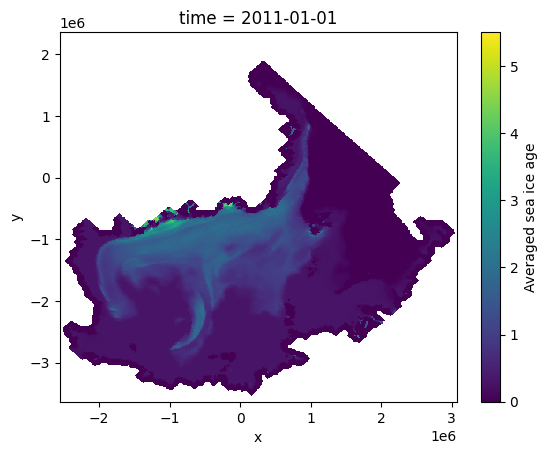

In [8]:
sia.isel(time=0).plot()

In [11]:
import matplotlib.pyplot as plt

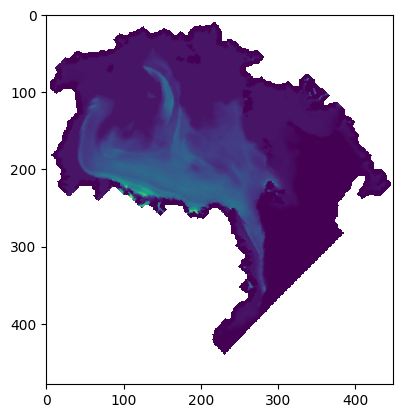

In [12]:
plt.imshow(sia.isel(time=0).to_numpy())

In [13]:
filename = f'{rootdir}Leo/results/pca_i100-550_j150-629/sithick_TOPAZ4b23_2011_2022.nc'

sit_tp, chrono = load_data.load_nc(filename, 'sithick', X_only=True)

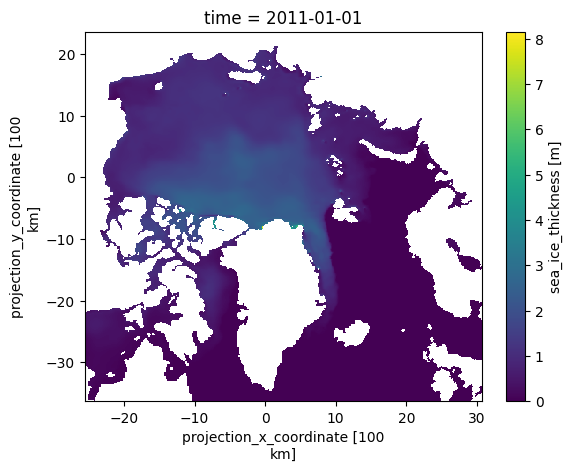

In [15]:
sit_tp.isel(time=0).plot()

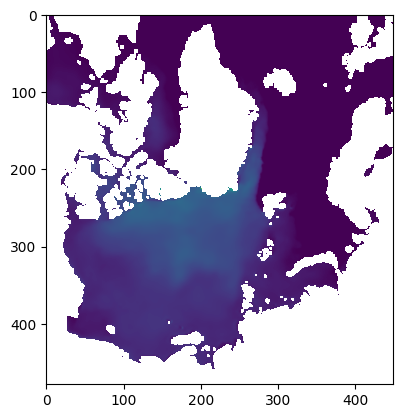

In [16]:
plt.imshow(sit_tp.isel(time=0).to_numpy())

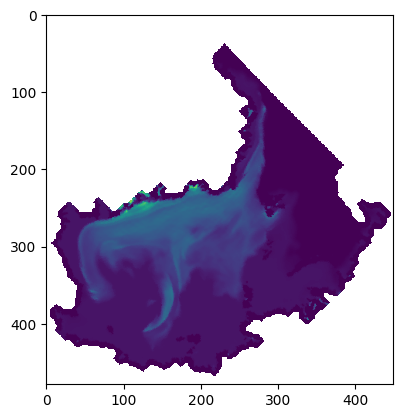

In [17]:
plt.imshow(sia.isel(time=0).to_numpy()[::-1])

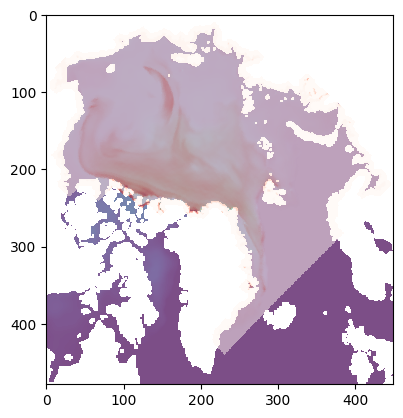

In [22]:
plt.imshow(sit_tp.isel(time=0).to_numpy()[::-1], alpha=.7)
plt.imshow(sia.isel(time=0).to_numpy(), alpha=0.5, cmap=plt.get_cmap('Reds'))